In [1]:
# Import Libraries
import numpy as np

from project_utils.bb_model         import BB_Model
from project_utils.feature_stats    import Feature_Statistics
from project_utils.feature_stats    import Regression_Container
from project_utils.acq_data_capture import Acq_Data_nD
from project_utils.surroagte_gp     import Surrogate_GP



Num_Points = 4


In [2]:
# Load Forrester model

Reg_Data = BB_Model(dataset = 'Synthetic_Reg', Feature_Counts=[10,8])

#Reg_Data.df().head()

In [3]:
Reg_Data.MPL()

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.23518162454906144


MLPRegressor(random_state=RandomState(MT19937) at 0x23E40689840)

In [4]:
Reg_Data.Random_Forest()

0.34636249456778045


RandomForestRegressor(random_state=RandomState(MT19937) at 0x23E40689840)

In [5]:
Reg_Data.GP()

-3.2512098815841597


GaussianProcessRegressor()

In [6]:
print(Reg_Data.get_features())

['Passive_0', 'Passive_1', 'Active_2', 'Active_3', 'Active_4', 'Active_5', 'Active_6', 'Active_7']


In [7]:
#Default settings
from unravel.tabular import UnRAVELTabularExplainer

X_train, X_test, y_train, y_test = Reg_Data.get_TT_data()

#Initializing the explainer object
Unravel_Exp = UnRAVELTabularExplainer(bbox_model           = Reg_Data.get_GP(),
                                      train_data           = X_train,
                                      categorical_features = Reg_Data.get_catagorical(),
                                      mode                 = Reg_Data.get_mode())

sur_GP = Surrogate_GP()



warning in stationary: failed to import cython module: falling back to numpy
warning in coregionalize: failed to import cython module: falling back to numpy
warning in choleskies: failed to import cython module: falling back to numpy


In [8]:
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
print('Mean 0:', mean)
print('Std 0: ', std)


Mean 0: [  5.96003486  13.30102828  11.59006257  18.26093875   5.61874905
   9.90773986 -19.22051074  12.79635744]
Std 0:  [5.20324771 1.4819846  4.28437136 2.17403321 3.47314989 4.72772218
 3.39802453 2.94537963]


In [9]:
# Generate explantion data for Random Forest

Reg_Stats = Feature_Statistics(feature_names = Reg_Data.get_features(), mode = Reg_Data.get_mode())

if Num_Points == 0: Num_Points = X_test.shape[0]

for test_instance in range(Num_Points):

    print('INSTANCE: ', test_instance)
       
    data_row  = np.array([X_test[test_instance]])
    
#    data_row  = np.array([0.4])

#    print('data row ',data_row)
    
    scores = Unravel_Exp.explain(X_init            = data_row.reshape(1, -1),
                                 feature_names     = Reg_Data.get_features(),
                                 alpha             = "FUR_W",
                                 max_iter          = 20,
                                 normalize         = False,
                                 interval          = 1,
                                 importance_method = "KL")
       
       
    f_predict = Reg_Data.get_Random_Forest().predict(data_row.reshape(1, -1))

#    e_predict = Unravel_Exp.exp_predict(data_row.reshape(1, -1))
#    e_predict = np.array(e_predict).ravel()
    
    acq_data = Unravel_Exp.get_acq_data()
    
    X, y = Unravel_Exp.get_surrogate_data()

    e_predict = sur_GP.predict(X, y)

#    print(f_predict, e_predict, acq_data.get_fe_x0())
    
#    scores = Unravel_Exp.permutation_importance()
    
    Reg_Stats.Add_Sample(sample_scores = scores,
                         outcome       = y_test[test_instance],
                         X_row         = data_row.reshape(1, -1),
                         f_prediction  = f_predict,
                         e_prediction  = e_predict.ravel(),
                         feopt         = acq_data.get_fe_x0(),
                         model         = Unravel_Exp.get_gpmodel())


INSTANCE:  0
Acq_Data_nD
[-6.77088861e-03  9.99999486e-06]
INSTANCE:  1
Acq_Data_nD
[-3.11829996e-06  9.91023008e-06]
INSTANCE:  2
Acq_Data_nD
[-3.67026284e-04  9.90114044e-06]
INSTANCE:  3
Acq_Data_nD
[-4.23293095e-05  9.54677871e-06]


In [10]:
import matplotlib.pyplot as plt


In [11]:
print(f_predict)
print(e_predict)


[-194.87946331]
[-4.23293095e-05  9.54677871e-06]


In [12]:
Reg_Stats.Feature_Counts(max_features=20, scaled=True, threshold=0.05)


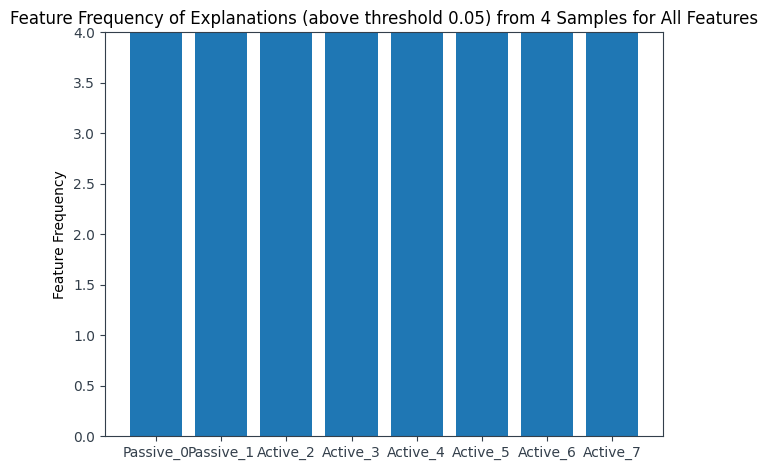

In [13]:
Reg_Stats.Frequency_Plot()


In [14]:
Reg_Stats.Fidelity()

Average, Var, and Max Differences:
y - BB(x):           31.80129193763663  :  545.2295396726514  :  62.514465945867244
y - exp(x):          182.34967389358025  :  808.1768596273927  :  215.28103194626794
BB(x) - exp(x):      150.54838195594363  :  1677.419612577716  :  194.87942098362072
Average exp(x) var:  9.839536022334612e-06


In [15]:
Reg_Stats.Jaccard_Values()

Mean Jaccard Similarity:  0.3988095238095238
Mean Jaccard Distance:    0.6011904761904762


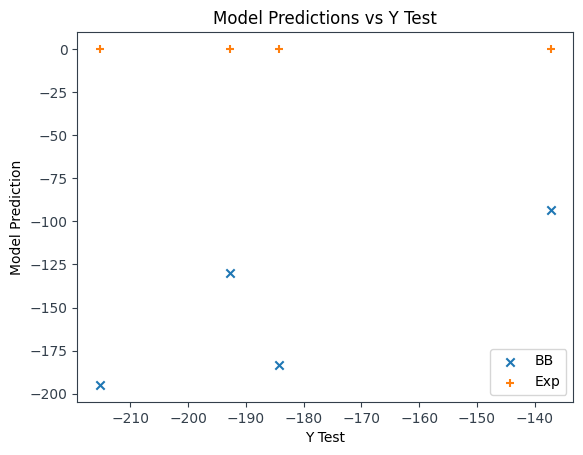

In [16]:
Reg_Stats.Reg_Fidelity_Graph()

top_features True
top_features (4, 8)


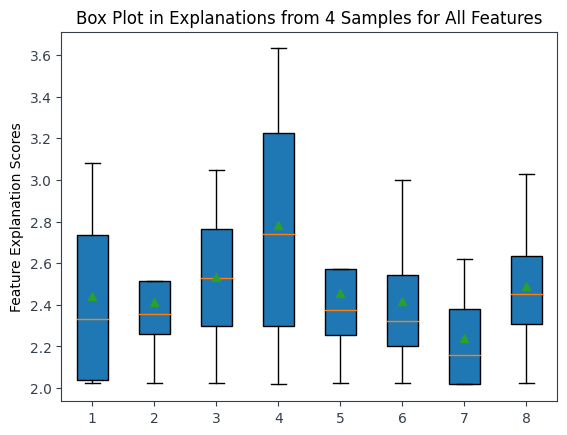

1 -      Passive_0
2 -      Passive_1
3 -      Active_2
4 -      Active_3
5 -      Active_4
6 -      Active_5
7 -      Active_6
8 -      Active_7


In [17]:
Reg_Stats.Box_Plot()


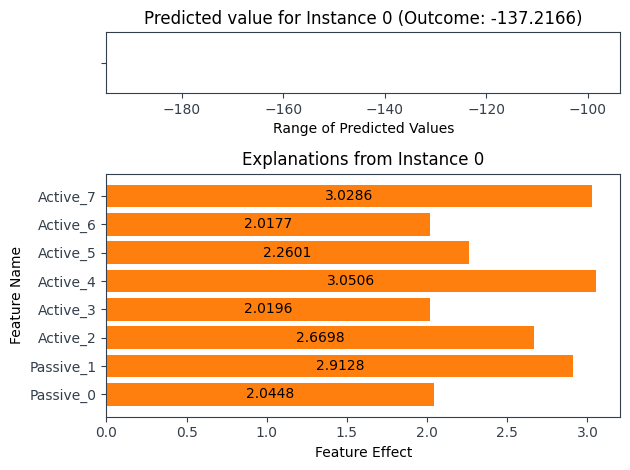

In [18]:
Reg_Stats.View_Explanation(instance = 0)

In [19]:
acq_data.Add_BB_model(Reg_Data.get_Random_Forest())
acq_data.Create_BB_plot()

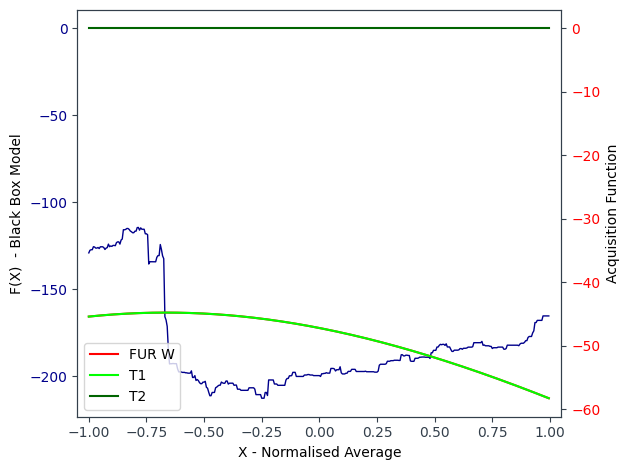

In [20]:
acq_data.plot_point(0)

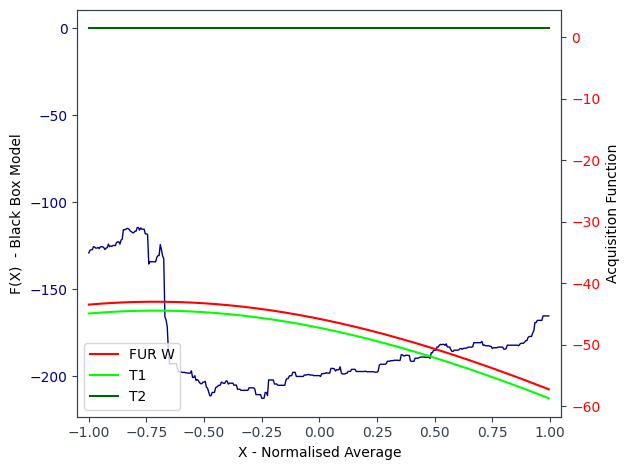

In [21]:
acq_data.plot_point(5)

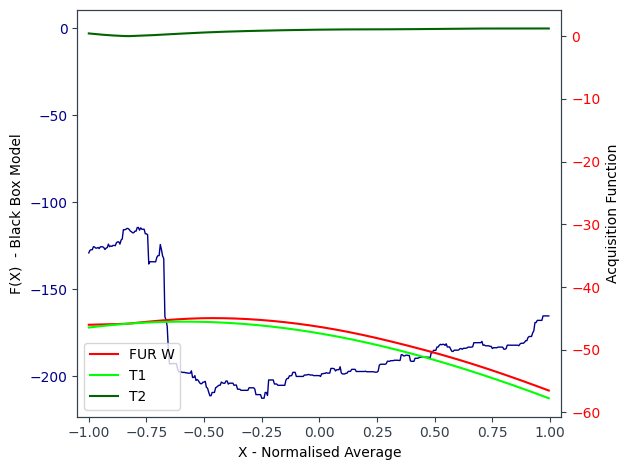

In [22]:
acq_data.plot_point(10)

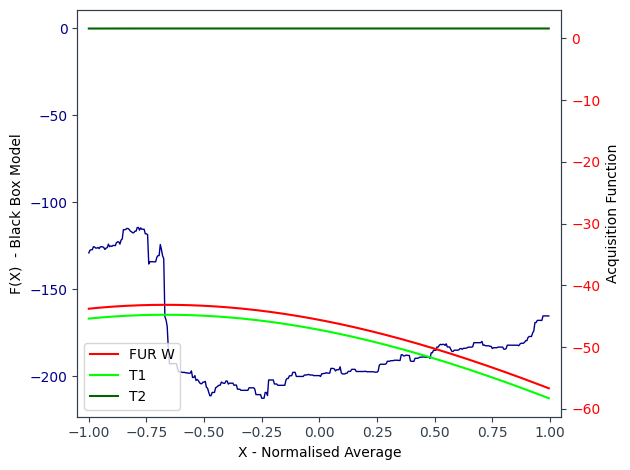

In [23]:
acq_data.plot_point(15)

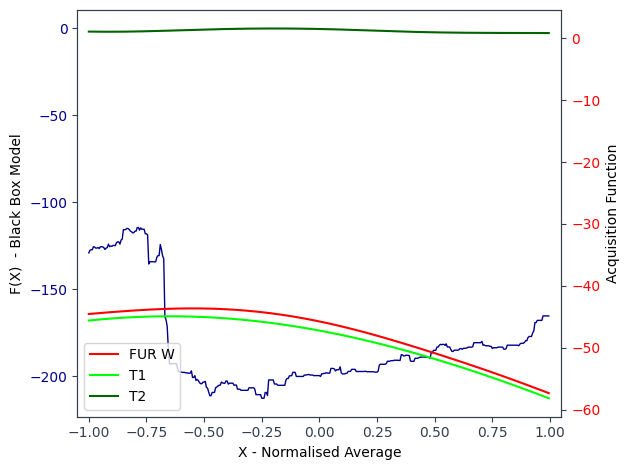

In [24]:
acq_data.plot_point(19)

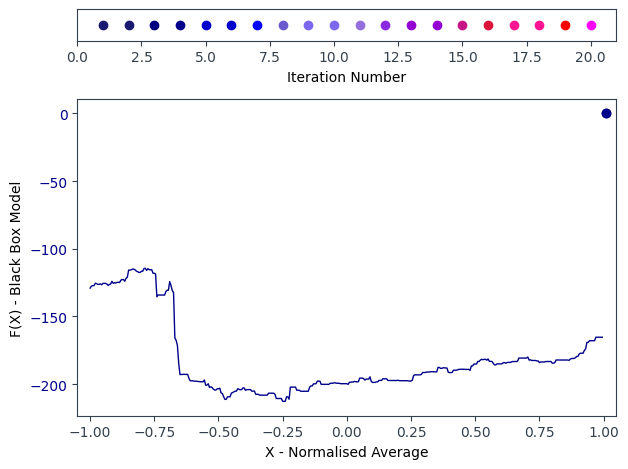

In [25]:
acq_data.plot_all()